# Image super resolution

In [1]:
!pip install Pillow
!pip install scipy==1.2.2

In [2]:
import scipy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy import misc
from scipy import ndimage
import cv2
import numpy as np
import math
import sys, time

In [3]:
from skimage.io import imread
import scipy
from scipy import misc
from IPython.display import display, Image
import imageio
img = imageio.imread('butterfly_GT.bmp')
imageio.imwrite('output_GT.jpg', img)

In [4]:
def imread(path, is_grayscale=True):
    """
    Read image from the giving path.Default value is gray-scale, and image is read by YCbCr format as the paper.
    """
    if is_grayscale:
        return misc.imread(path, flatten=True, mode='YCbCr').astype(np.float32)
    else:
        return misc.imread(path, mode='YCbCr').astype(np.float32)

In [5]:
def modcrop(image, scale=3):
    """In order to reduce and increase the size of an image, the first step is to ensure that there will be no unused space at the end. Scale factor and modulo of height (and width) must be determined. Subtract this number from the height and width of the original picture size to find the modulo. Despite the scaling operation, there would be no unused space."""
    if len(image.shape) == 3:
        h, w, _ = image.shape
        h = h - np.mod(h, scale)
        w = w - np.mod(w, scale)
        image = image[0:h, 0:w, :]
    else:
        h, w = image.shape
        h = h - np.mod(h, scale)
        w = w - np.mod(w, scale)
        image = image[0:h, 0:w]
    return image

In [10]:
def preprocess(path, scale=3):
    """
    Preprocess single image file
      (1) Read original image as YCbCr format (and grayscale as default)
      (2) Normalize
      (3) Apply image file with bicubic interpolation
    """
    image = imread(path, is_grayscale=True)
    label_ = modcrop(image, scale)
    # Must be normalized
    label_ = label_ / 255.
    input_ = ndimage.interpolation.zoom(label_, (1. / scale), prefilter=False)
    input_ = ndimage.interpolation.zoom(input_, (scale / 1.), prefilter=False)
    return input_, label_

In [11]:
"""Define the model weights and biases 
"""
## set the weight of three conv layers
# add hyper parameter numbers
# conv1 layer with biases: 64 filters with size 9 x 9
# conv2 layer with biases and relu: 32 filters with size 1 x 1
# conv3 layer with biases and NO relu: 1 filter with size 5 x 5
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=9, padding=4)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=1, padding=0)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=5, padding=2)
    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = self.conv3(out)
        return out

In [12]:
import skimage
from skimage import metrics
"""Load the pre-trained model file
"""
model = SRCNN()
model.load_state_dict(torch.load('model.pth'))
model.eval()

SRCNN(
  (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (conv2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
  (conv3): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
)

In [13]:
LR_image, HR_image = preprocess('butterfly_GT.bmp')
# transform the input to 4-D tensor
input_ = np.expand_dims(np.expand_dims(LR_image, axis=0), axis=0)
input_ = torch.from_numpy(input_)
input_.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  


torch.Size([1, 1, 255, 255])

In [14]:
display(LR_image)

array([[0.25920767, 0.25513822, 0.2494797 , ..., 0.22881679, 0.23044209,
        0.2311485 ],
       [0.2788774 , 0.2700236 , 0.25395328, ..., 0.22590221, 0.22799058,
        0.22887225],
       [0.3138354 , 0.29562753, 0.25912508, ..., 0.21665223, 0.21967468,
        0.2209137 ],
       ...,
       [0.2154972 , 0.2194135 , 0.2315378 , ..., 0.43357426, 0.43390125,
        0.43403882],
       [0.21987672, 0.22691946, 0.24443674, ..., 0.43563727, 0.43621522,
        0.43647704],
       [0.22228926, 0.2306639 , 0.25035676, ..., 0.4364397 , 0.43717626,
        0.43751568]], dtype=float32)

In [15]:
display(HR_image)

array([[0.12304706, 0.17582352, 0.2643843 , ..., 0.24218823, 0.2461098 ,
        0.2343451 ],
       [0.10359216, 0.1251647 , 0.15560001, ..., 0.22901568, 0.23293725,
        0.23775294],
       [0.2531686 , 0.13490589, 0.10892157, ..., 0.23798823, 0.2419098 ,
        0.24583137],
       ...,
       [0.19275686, 0.20656471, 0.1734902 , ..., 0.43803138, 0.42969802,
        0.44169804],
       [0.17764705, 0.19105098, 0.20729412, ..., 0.43366274, 0.43754116,
        0.4456196 ],
       [0.17886275, 0.1911804 , 0.2561451 , ..., 0.42974117, 0.44864705,
        0.44169804]], dtype=float32)

In [16]:
"""Run the model and get the SR image
"""
with torch.no_grad():
    output_ = model(input_)
imageio.imwrite('output.jpg',LR_image)
skimage.metrics.peak_signal_noise_ratio(HR_image,LR_image)

20.497630181368823

In [17]:
SR_image = output_.numpy()
SR_image = np.reshape(SR_image, (255, 255))
skimage.metrics.peak_signal_noise_ratio(HR_image,SR_image)
imageio.imwrite('output1.jpg',SR_image)
imageio.imwrite('output2.jpg',HR_image)

In [18]:
skimage.metrics.peak_signal_noise_ratio(HR_image,LR_image)

20.497630181368823

In [19]:
skimage.metrics.peak_signal_noise_ratio(HR_image,SR_image)

22.922696338909144

## Original Resolution Image

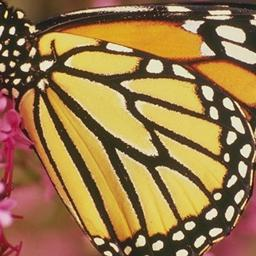

In [20]:
display(Image(filename='output_GT.jpg'))

## Low Resolution Image

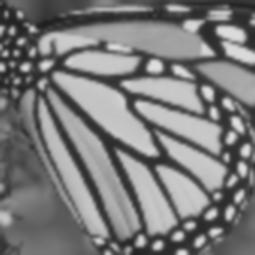

In [22]:
display(Image(filename='output.jpg'))

## High resolution Image

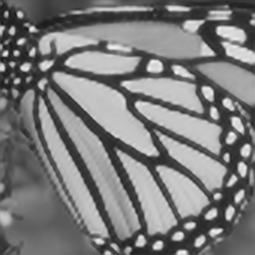

In [21]:
display(Image(filename='output1.jpg'))

## Super Resolution Image

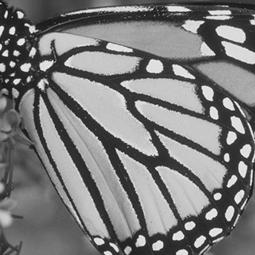

In [23]:
display(Image(filename='output2.jpg'))

We used following layers to get super resolution image.

conv1 layer with biases: 64 filters with size 9 x 9

conv2 layer with biases and relu: 32 filters with size 1 x 1

conv3 layer with biases and NO relu: 1 filter with size 5 x 5